<a href="https://colab.research.google.com/github/dvVenuto/Bellman_Ford/blob/master/AutoDiffMLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Pytorch 2 layer MLP Implementation

Pytorch is a package that allows easier implementation of deep learning achitectures.  It's main benefits are easy implementation of the matrix computation operations and automatic differentiation.  Parameters and operations are tracked and the package computes the gradients automatically.  You can define MLPs as a `nn.Module` class. After layers are defined, you choose how they operate on the input using the `forward` function.

In [2]:
#Pytorch Implementation of a 2 Layer MLP
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

#We first define an nn.Module, 
class MLP(nn.Module):
  def __init__(self, inputs=2, outputs=2, hiddens=32):
    super(MLP, self).__init__()
    #Define the layers in your MLP
    self.fc1 = nn.Linear(inputs, hiddens)
    self.fc2 = nn.Linear(hiddens, outputs)
  
  def forward(self, x):
    #Define operations on input x using the layers that were defined
    x = F.relu(self.fc1(x))
    x = F.softmax(self.fc2(x), dim =1)
    return x
    

Torch objects operate on `torch.Tensor` objects.  You must take all numpy datasets and convert them to the correct type of Tensor object.

Once the optimizer and loss function are defined, its easy to use them to update the parameters in the network.  An example training loop is below.

In [3]:
import numpy as np
#%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace
import warnings
from sklearn import datasets

warnings.filterwarnings('ignore')
dataset = datasets.load_iris()

#Initalize your MLP
net = MLP()

#To use GPUs, set a device (cuda) and add it to your net
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)

#define hyperparameters
learning_rate = 0.1
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)

x, y = dataset['data'][:,[1,2]], dataset['target']
y =  y == 1

#The dataset must be converted to a tensor of the correct type
x_tensor = Variable(torch.from_numpy(x).float())
y_tensor   = Variable(torch.from_numpy(y)).long()

#Training loop
epochs = 1000
for t in range(epochs):
    pred = net(x_tensor)

    optimizer.zero_grad()
    loss = loss_fn(pred, y_tensor)

    loss.backward()
    optimizer.step()


print("Done!")

    


Done!


## Plotting the results on the iris dataset

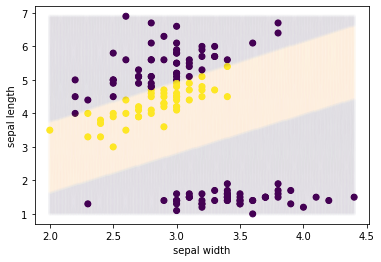

In [4]:
yh = net(x_tensor) 
yh = torch.argmax(yh, axis=1)
yh = yh.numpy()
x0v = np.linspace(np.min(x[:,0]), np.max(x[:,0]), 200)
x1v = np.linspace(np.min(x[:,1]), np.max(x[:,1]), 200)
x0,x1 = np.meshgrid(x0v, x1v)
x_all = np.vstack((x0.ravel(),x1.ravel())).T

x_all_tensor = Variable(torch.from_numpy(x_all).float())

yh_all = net(x_all_tensor) 
yh_all = torch.argmax(yh_all, axis=1)
yh_all = yh_all.numpy()

plt.scatter(x[:,0], x[:,1], c=yh, marker='o', alpha=1)
plt.scatter(x_all[:,0], x_all[:,1], c=yh_all, marker='.', alpha=.01)

plt.ylabel('sepal length')
plt.xlabel('sepal width')
plt.show()

### Tensorflow implementation

Tensorflow is very similar to pytorch, also allowing auto differentiation and fast matrix computations.  Objects are stored as `tf.Tensor` objects.  Keras is a wrapper over Tensorflow that allows very easy definition of neural networks.  

In [164]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from sklearn.preprocessing import LabelEncoder
from pandas import get_dummies


x_tf = np.array(x).astype('float32')

#It is generally proper form to cast to a specific tensorflow Tensor type (tf.int32, tf.float32)
y_tf = np.array(y).astype('float32')


## Model definition in Tensorflow

We can easily define a model as a `Sequential` object in keras and add `Dense` (fully connected layers) to it, each with its own activation.

In [165]:
# We can see its very easy to define a neural network using keras Sequential function

model = Sequential()
model.add(Dense(32, input_shape=(x_tf.shape[1],), activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

#We can print a summary of our model
model.summary()

Model: "sequential_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_81 (Dense)            (None, 32)                96        
                                                                 
 dense_82 (Dense)            (None, 32)                1056      
                                                                 
 dense_83 (Dense)            (None, 1)                 33        
                                                                 
Total params: 1,185
Trainable params: 1,185
Non-trainable params: 0
_________________________________________________________________


## Tensorflow optimization and training loop

It is now easy to see that we can define an optimizer similarly to pytorch.  the `compile` function allows us to define both the optimizer and loss for our model.  We can simply call fit given the inputs and labels for out model to train it.

In [166]:
#Defining an optimizer and training loop is equally easy

sgd = SGD(learning_rate=0.1)
model.compile(optimizer=sgd, loss=keras.losses.BinaryCrossentropy(), metrics=['accuracy'])

#Simply use the fit function given the input data
model.fit(x_tf, y_tf, epochs=1000, batch_size=y_tf.shape[0], verbose=0)

## Plotting the IRIS dataset using tensorflow

1250/1250 [==============================] - 2s 1ms/step


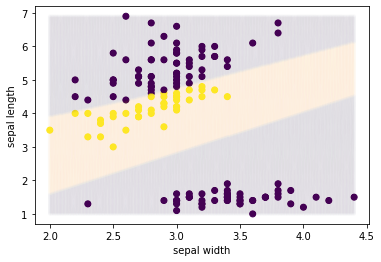

In [167]:
yh = model.predict(x_tf) 
yh = yh > 0.5
x0v = np.linspace(np.min(x[:,0]), np.max(x[:,0]), 200)
x1v = np.linspace(np.min(x[:,1]), np.max(x[:,1]), 200)
x0,x1 = np.meshgrid(x0v, x1v)
x_all = np.vstack((x0.ravel(),x1.ravel())).T

x_tf_all = np.array(x_all).astype('float32')

yh_all = model.predict(x_tf_all) 
yh_all = yh_all > 0.5
yh_all = np.array(yh_all)

plt.scatter(x[:,0], x[:,1], c=yh, marker='o', alpha=1)
plt.scatter(x_all[:,0], x_all[:,1], c=yh_all, marker='.', alpha=.01)

plt.ylabel('sepal length')
plt.xlabel('sepal width')
plt.show()